# Project Bankruptcy
## Group members：
| NO  |NAME| 
|-----|----|
|  1  |Divya Khanolkar| 
|  2  |Chi Wen Lee|
|  3  |Yunhan Chiu|
|  4  |Adithya Narayan|
|  5  |Max Szurglies|
|  6  |Rodrigo Ferreyros|

In [276]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# data resampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
    AdaBoostClassifier,
)

from lightgbm import LGBMClassifier

# feature extraction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# feature selection
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    VarianceThreshold,
    mutual_info_classif,
)

# model evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    roc_curve,
    roc_auc_score,
)

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV

## Data Loading and process
- load data and check population size
- split data to train and test data

### Load data and check population size
- df: original data
- df_rename: 'Bankrupt?' : 'target', features: Attr1~Attr95

In [277]:
# read in dataset
df = pd.read_csv("data.csv")
df_rename = df.copy()
population_size = len(df)
# rename columns
df.rename(columns={"Bankrupt?": "target"}, inplace=True)
index = 0
for col in df_rename.columns:
    if col == "Bankrupt?":
        df_rename.rename(columns={col: "target"}, inplace=True)
    else:
        df_rename.rename(columns={col: "Attr" + str(index)}, inplace=True)
    index += 1

# checking data population
print("data shape:", df_rename.shape)
# checking target incidence
print("\ndata incidence", df_rename.target.value_counts(normalize=True))


data shape: (6819, 96)

data incidence 0    0.967737
1    0.032263
Name: target, dtype: float64


$\implies$ 3% of target '1': imbalanced data</br>
$\implies$ 96 features: high-dimensional dataset


array([[<AxesSubplot: title={'center': 'target'}>,
        <AxesSubplot: title={'center': 'Attr1'}>,
        <AxesSubplot: title={'center': 'Attr2'}>,
        <AxesSubplot: title={'center': 'Attr3'}>,
        <AxesSubplot: title={'center': 'Attr4'}>,
        <AxesSubplot: title={'center': 'Attr5'}>,
        <AxesSubplot: title={'center': 'Attr6'}>,
        <AxesSubplot: title={'center': 'Attr7'}>,
        <AxesSubplot: title={'center': 'Attr8'}>,
        <AxesSubplot: title={'center': 'Attr9'}>],
       [<AxesSubplot: title={'center': 'Attr10'}>,
        <AxesSubplot: title={'center': 'Attr11'}>,
        <AxesSubplot: title={'center': 'Attr12'}>,
        <AxesSubplot: title={'center': 'Attr13'}>,
        <AxesSubplot: title={'center': 'Attr14'}>,
        <AxesSubplot: title={'center': 'Attr15'}>,
        <AxesSubplot: title={'center': 'Attr16'}>,
        <AxesSubplot: title={'center': 'Attr17'}>,
        <AxesSubplot: title={'center': 'Attr18'}>,
        <AxesSubplot: title={'center': 

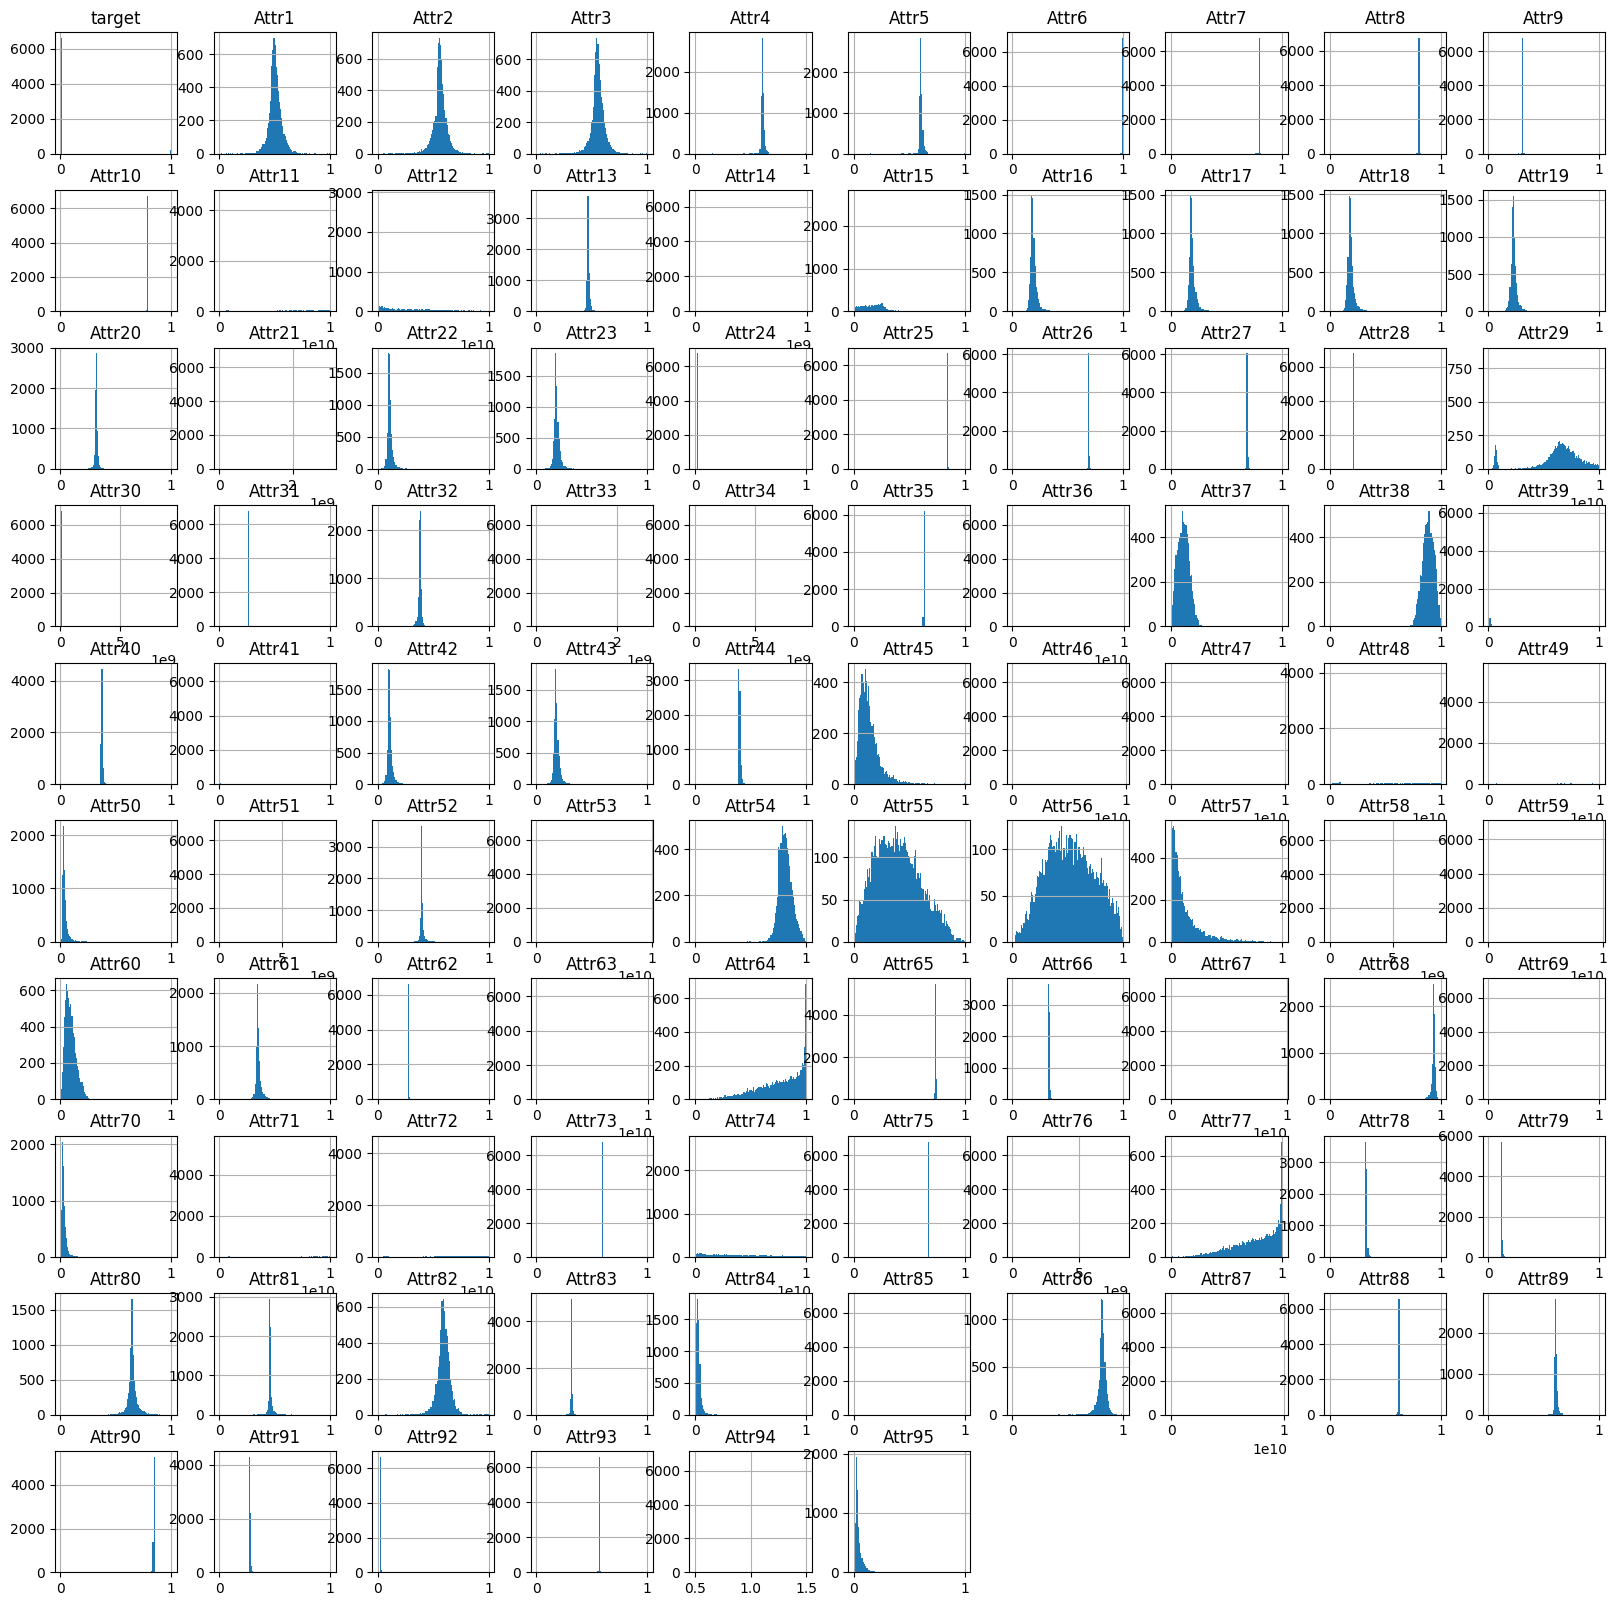

In [278]:
# check the variance of the features
df_rename.hist(bins=100, figsize=(20, 20))

our features have similar range (most of them are 0 to 1)

### Split data to train and test data
- X: all features data
- y: target data
- X_train, X_test, y_train, y_teat splited by 'train_test_split' with test-size 30%

In [279]:
# assign Data to X and y
X = df_rename.drop(columns="target")
y = df_rename.target

In [280]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)
print("X_train shape:", X_train.shape,
      "\nX_test shape:", X_test.shape,
      "\ny_train shape:", y_train.shape,
      "\ny_test shape:", y_test.shape,
     )

X_train shape: (4773, 95) 
X_test shape: (2046, 95) 
y_train shape: (4773,) 
y_test shape: (2046,)


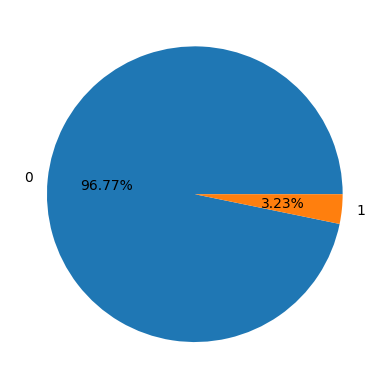

In [281]:
data = df["target"].value_counts()
plt.pie(data, autopct="%1.2f%%", labels=data.index)
plt.show()

In [282]:
# Find the best resampled dataset
models = [RandomForestClassifier(), 
          LogisticRegression(solver="liblinear"),  # note: Logistic regression failed to converge in most cases with lbfgs algorithm, so we change to liblinear
          KNeighborsClassifier(), 
          DecisionTreeClassifier(), 
          AdaBoostClassifier(),
          XGBClassifier(),
          LGBMClassifier(),
         ]
models_name = ["RandomForestClassifier", 
               "LogisticRegression", 
               "KNeighborsClassifier", 
               "DecisionTreeClassifier", 
               "AdaBoostClassifier",
               "XGBClassifier",
               "LGBMClassifier"
              ]

# claim resample constants
C_ORIGINAL = "Original"
C_UNDERSAMPLING = "UnderSampling"
C_OVERSAMPLING = "OverSampling"
C_SMOTE = "SMOTE"

# claim extraction constants
C_PCA = "PCA"

# claim feature selection constants
C_TARGETHIGHCORR = "TargetHighCorr"
C_REMOVE5VIF = "remove5VIF with targetHighCorr"
C_MODELREDUCEFEATURE = "ModelReduceFeature"
C_KBESTMUTUALINFO = "kBestMutualInfo"
C_OPT = "tuneHyperparameter"

# model data init
data_names = [C_ORIGINAL, C_UNDERSAMPLING, C_OVERSAMPLING, C_SMOTE]
models_f1Score = pd.DataFrame(columns=models_name, index=data_names)
models_accurracy = pd.DataFrame(columns=models_name, index=data_names)

# for later combined charts
auc_rocs = {}

In [283]:
def update_aucs(md_name, data_name, auc_val):
    if not auc_rocs or data_name not in auc_rocs:
        auc_rocs[data_name] = []
        auc_rocs[data_name].append(auc_val)
    exist = False
    # exist replace
    for i, data in enumerate(auc_rocs[data_name]):
        if data['model_name'] == md_name:
            data = auc_val
            exist = True
            break
    # not exist append
    if not exist:
        auc_rocs[data_name].append(auc_val)

In [284]:
def print_roc_auc_curve_cm(y_test, y_pre, probabilities, md_name, data_name):
    # select the probabilities for label 1.0
    y_proba = probabilities[:, 1]

    # calculate false positive rate and true positive rate at different thresholds
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_test, y_proba, pos_label=1
    )
    
    # calculate AUC
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # save combined data to global variables
    auc_val = {"model_name": md_name, "auc": roc_auc, "fpr": false_positive_rate, "tpr": true_positive_rate}
    update_aucs(md_name, data_name, auc_val)

    # create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12, 4), dpi=72)
    plot_title = (
            md_name
            + "("
            + data_name
            + ") F1s:"
            + format(models_f1Score[md_name][data_name], ".2f")
        )

    ax1.set_title(plot_title)
    # plot the false positive rate on the x axis and the true positive rate on the y axis
    roc_plot = ax1.plot(
        false_positive_rate, true_positive_rate, label="AUC = {:0.2f}".format(roc_auc)
    )
    ax1.legend(loc=0)
    ax1.plot([0, 1], [0, 1], ls="--")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate")

    # print confusion matrix
    c_matrix = confusion_matrix(y_test, y_pre)
    ax2.set_title(plot_title)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Not bankrupt", "Is bankrupt"]
    )
    disp.plot(ax=ax2)
    fig

In [285]:
def get_f1score_accuracy(y_test, y_pre):
    return f1_score(y_test, y_pre, average="macro"), accuracy_score(y_test, y_pre)

In [286]:
def testModels(X_train, y_train, X_test, y_test, data_name, needPrint):
    # init model f1 and accuracy
    models_f1Score.loc[data_name] = np.zeros(len(models))
    models_accurracy.loc[data_name] = np.zeros(len(models))
    
    for md_name, md in zip(models_name, models):
        # predict
        md.fit(X_train, y_train)
        y_pre = md.predict(X_test)
        probabilities = md.predict_proba(X_test)
        
        # get f1 score and accuracy
        models_f1Score.loc[data_name,md_name], models_accurracy.loc[data_name,md_name] = get_f1score_accuracy(y_test, y_pre)
    
        if needPrint:
            # print roc curve and confusion matrix
            print_roc_auc_curve_cm(y_test, y_pre, probabilities, md_name, data_name)
            # overfitting check
            train_pre = md.predict(X_train)
            train_acc = accuracy_score(y_train, train_pre)
            print(md_name+": train accurancy-",format(train_acc,".2f"),
                  "and test accruancy-",format(models_accurracy[md_name][data_name],".2f")
                 )    

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.97
LogisticRegression: train accurancy- 0.97 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.97
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.98 and test accruancy- 0.96
XGBClassifier: train accurancy- 1.00 and test accruancy- 0.97
LGBMClassifier: train accurancy- 1.00 and test accruancy- 0.97


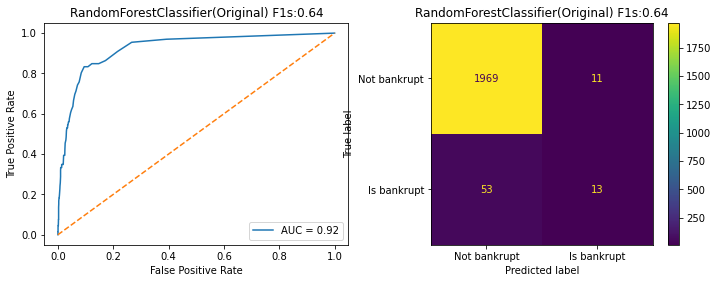

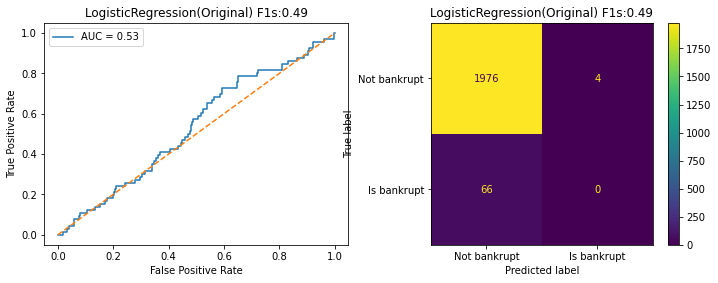

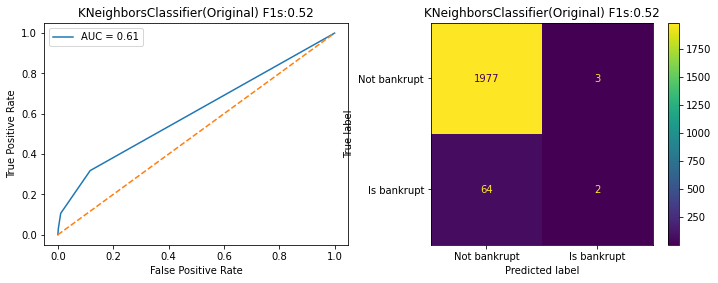

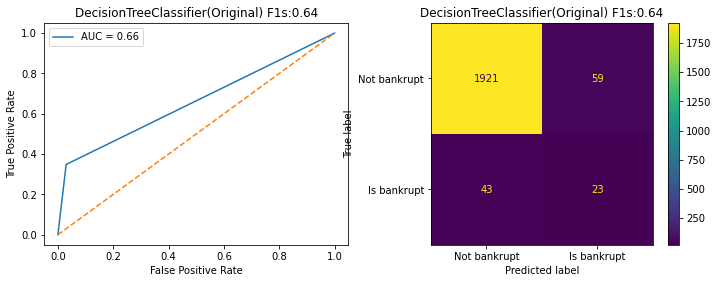

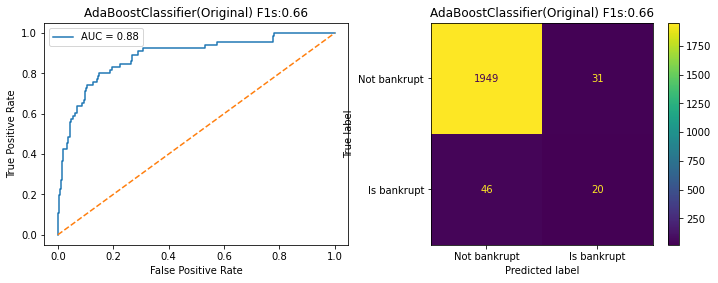

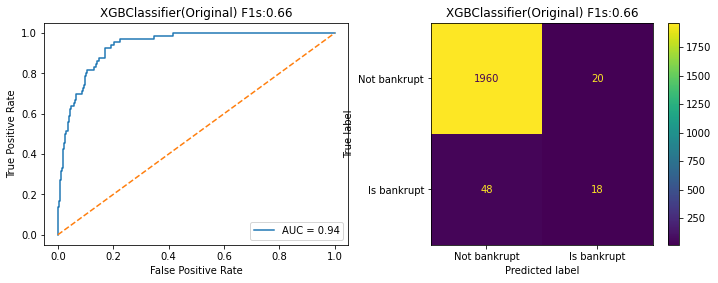

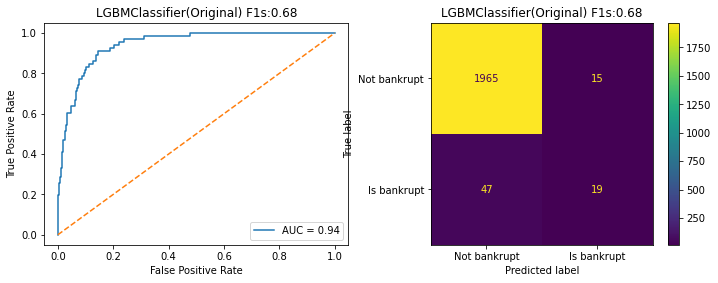

In [287]:
testModels(X_train, y_train, X_test, y_test, C_ORIGINAL, True)

## Resample Imbalanced data
- Using imblearn library </br>
  1. Undersampling: </br>This technique eliminates or deletes the data points of the majority class to make an equal ratio of major and minor classes.There is a various method for undersampling like Tomek’s links, EditedNearestNeighbours, CondensedNearestNeighbour, InstanceHardnessThreshold, etc.
  2. Oversampling: </br>This technique redistributes randomly the minority class data points to increase the ratio in the dataset.It duplicates the existing data points of minority class and equalizes the ratio of majority and minority class.
  3. SMOTE (Synthetic Minority Oversampling Technique):</br>SMOTE selects the data points of the minority class in feature space to draw a line between those points and generate new points along with the line. Thus this technique synthesizes new data points for minority class and oversample that class.

In [288]:
models_f1Score.iloc[:1]

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,XGBClassifier,LGBMClassifier
Original,0.636448,0.491298,0.519838,0.642474,0.661255,0.664551,0.682234


=> LGBMClassifier has best f1

In [289]:
# this function to get best resample ratio
def get_best_ratio(from_rate, to_rate):
    ratios = np.arange(from_rate, to_rate, 0.1)
    best_ratio = 0
    best_f1Score = 0
    for ratio in ratios:
        rus = RandomUnderSampler(sampling_strategy = ratio, random_state=0)
        X_underSampling, y_underSampling = rus.fit_resample(X_train, y_train)
        testModels(X_underSampling, y_underSampling, X_test, y_test, C_UNDERSAMPLING, False)
        if best_f1Score < models_f1Score['XGBClassifier'][C_UNDERSAMPLING]:
            best_f1Score = models_f1Score['GradientBoostingClassifier'][C_UNDERSAMPLING]
            best_ratio = ratio
    print("best_ratio:",best_ratio) 
    print("best_f1Score:",best_f1Score) 

In [290]:
# check which ratio is best for our resampling methods
def get_best_ratio(data_name):
    ratios = np.arange(0.1, 1, 0.1)
    best_ratio = 0
    best_f1Score = models_f1Score["LGBMClassifier"][C_ORIGINAL]
    for ratio in ratios:
        rus = RandomUnderSampler(sampling_strategy = ratio, random_state=0)
        X_underSampling, y_underSampling = rus.fit_resample(X_train, y_train)
        testModels(X_underSampling, y_underSampling, X_test, y_test, data_name, False)
        best_ratio = ratio if models_f1Score["LGBMClassifier"][data_name] > best_ratio else best_ratio
    print("best_ratio: ", best_ratio)
    return round(best_ratio, 1)

In [291]:
# Undersampling
best_undersample_ratio = get_best_ratio(C_UNDERSAMPLING)
rus = RandomUnderSampler(sampling_strategy = best_undersample_ratio, random_state=0)
X_underSampling, y_underSampling = rus.fit_resample(X_train, y_train)
print(
    "X_underSampling's shape:",
    X_underSampling.shape,
    "y_underSampling's shape:",
    y_underSampling.shape,
)
print("y_underSampling:\n", y_underSampling.value_counts(normalize=True))
testModels(X_underSampling, y_underSampling, X_test, y_test, C_UNDERSAMPLING, False)

best_ratio:  0.7000000000000001
X_underSampling's shape: (374, 95) y_underSampling's shape: (374,)
y_underSampling:
 0    0.588235
1    0.411765
Name: target, dtype: float64


In [292]:
# Oversampling
best_over_ratio = get_best_ratio(C_OVERSAMPLING)
ros = RandomOverSampler(sampling_strategy = best_over_ratio, random_state=0)
X_overSampling, y_overSampling = ros.fit_resample(X_train, y_train)
print(
    "X_overSampling's shape:",
    X_overSampling.shape,
    "y_overSampling's shape:",
    y_overSampling.shape,
)
print("y_overSampling:\n", y_overSampling.value_counts(normalize=True))
testModels(X_overSampling, y_overSampling, X_test, y_test, C_OVERSAMPLING, False)

best_ratio:  0.7000000000000001
X_overSampling's shape: (7852, 95) y_overSampling's shape: (7852,)
y_overSampling:
 0    0.588258
1    0.411742
Name: target, dtype: float64


In [293]:
# SMOTE
best_smote_ratio = get_best_ratio(C_SMOTE)
sm = SMOTE(sampling_strategy = best_smote_ratio, random_state=0)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print("X_smote's shape:", X_smote.shape, "y_smote's shape:", y_smote.shape)
print("y_smote:\n", y_smote.value_counts(normalize=True))
testModels(X_smote, y_smote, X_test, y_test, C_SMOTE, False)

best_ratio:  0.7000000000000001
X_smote's shape: (7852, 95) y_smote's shape: (7852,)
y_smote:
 0    0.588258
1    0.411742
Name: target, dtype: float64


## Check overfitting by learning depths
- RandomForest Classifier
- KNeighbors Classifier 
- Decision Tree Classifier</br>
Note that we use accuracy comparision between train and test data for the Logistic Regression to check overfitting problem. </br>
However, the accuracy comparision of other three models above is hard to indentify overfitting. </br>
Therefore, we check overfitting problem for these three models by learning depths </br>

In [294]:
def check_overfitting(X_train, y_train, X_test, y_test, max_depth):
    
    title_name = ["RandomForestClassifier", 
                  "KNeighborsClassifier", 
                  "DecisionTreeClassifier", 
                  "AdaBoostClassifier",
                  "XGBClassifier",
                  "LGBMClassifier",
                 ]
    
    models = [RandomForestClassifier(), 
              KNeighborsClassifier(), 
              DecisionTreeClassifier(), 
              AdaBoostClassifier(),
              XGBClassifier(),
              LGBMClassifier(),
             ]
    
    # plot figure
    fig, sub_figs = plt.subplots(1, 6, sharex=False, figsize=(15, 5), dpi=72)
    # evaluate a decision tree for each depth

    depths = [i for i in range(1, max_depth)]
    for i, model in enumerate(models):

        # define lists to collect scores
        train_acc_scores, test_f1_scores = list(), list()

        for count in depths:
            if type(model) == type(RandomForestClassifier()):
                model == RandomForestClassifier(max_depth=count)
            elif type(model) == type(KNeighborsClassifier()):
                model = KNeighborsClassifier(n_neighbors=count)
            elif type(model) == type(DecisionTreeClassifier()):
                model = DecisionTreeClassifier(max_depth=count)
            elif type(model) == type(AdaBoostClassifier()):
                model = AdaBoostClassifier(n_estimators=count)
            elif type(model) == type(XGBClassifier()):
                model = XGBClassifier(max_depth=count)
            elif type(model) == type(LGBMClassifier()):
                model = LGBMClassifier(max_depth=count)
            else:
                print("unhandled model")
                break
            
            # fit model on the training dataset
            model.fit(X_train, y_train)
            
            # evaluate on the train dataset
            train_predict = model.predict(X_train)
            train_acc = accuracy_score(y_train, train_predict)
            train_acc_scores.append(train_acc)
            
            # evaluate on the test dataset
            test_predict = model.predict(X_test)
            test_acc = accuracy_score(y_test, test_predict)
            test_f1_scores.append(test_acc)
        
        # plot of train and test scores vs tree depth
        sub_figs[i].set_title(title_name[i])
        sub_figs[i].plot(depths, train_acc_scores, "-o", label="Train")
        sub_figs[i].plot(depths, test_f1_scores, "-o", label="Test")
        sub_figs[i].legend()
    fig

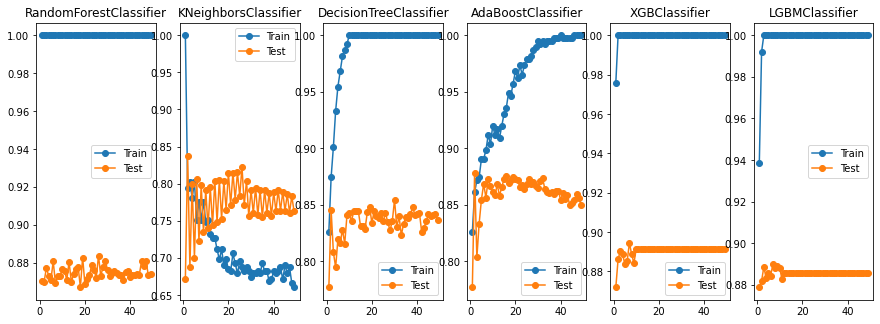

In [295]:
check_overfitting(X_underSampling, y_underSampling, X_test, y_test, 50)

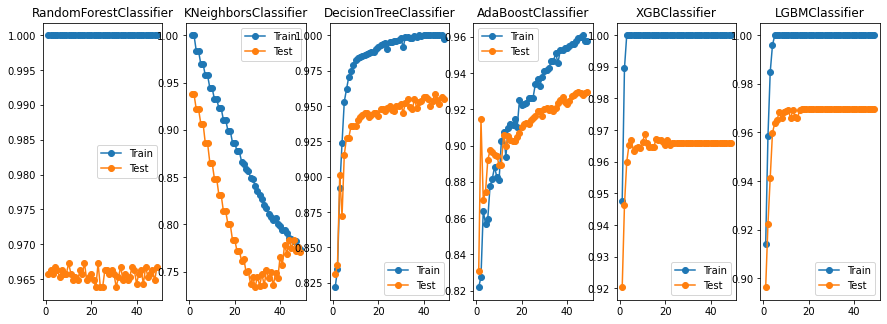

In [296]:
check_overfitting(X_overSampling, y_overSampling, X_test, y_test, 50)

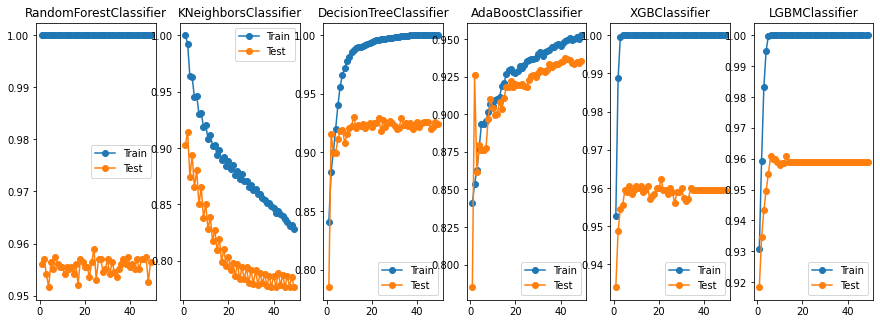

In [297]:
check_overfitting(X_smote, y_smote, X_test, y_test, 50)

In [298]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,XGBClassifier,LGBMClassifier
Original,0.636448,0.491298,0.519838,0.642474,0.661255,0.664551,0.682234
UnderSampling,0.611001,0.521652,0.452077,0.578128,0.581601,0.615889,0.620636
OverSampling,0.653226,0.512395,0.547065,0.633299,0.655234,0.690547,0.720277
SMOTE,0.692005,0.520045,0.534824,0.604186,0.669639,0.689372,0.697695


## Penalize Algorithms (Cost-Sensitive Training)
We use SVC to train data in balance with "class_weight='balanced'".

In [299]:
# we add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test) # check performance
print('ROC AUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))
print('F1 score:',f1_score(y_test, svc_predict))

ROC AUC score: 0.6214646464646465
Accuracy score: 0.7209188660801564
F1 score: 0.10641627543035993


## According to the above result, OVERSAMPLE has best accuracy, so we will continue to select features using oversampling data.

In [300]:
X_resample = X_overSampling.copy()
y_resample = y_overSampling.copy()
X_resample.shape, y_resample.shape

((7852, 95), (7852,))

## Feature Extraction by PCA
PCA is a dimensionality reduction technique that has four main parts: feature covariance, eigendecomposition, principal component transformation, and choosing components in terms of explained variance.

In [301]:
pipe_pca = Pipeline([
                ('scaler', StandardScaler()),  
                ('reducer', PCA(n_components=2))
                ])
# use fit_transform on our standardized training features
X_train_PCA = pipe_pca.fit_transform(X_train)

# use transform on our standardized test features
X_test_PCA = pipe_pca.transform(X_test)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.96
LogisticRegression: train accurancy- 0.97 and test accruancy- 0.97
KNeighborsClassifier: train accurancy- 1.00 and test accruancy- 0.95
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.97 and test accruancy- 0.96
XGBClassifier: train accurancy- 0.98 and test accruancy- 0.96
LGBMClassifier: train accurancy- 0.99 and test accruancy- 0.96


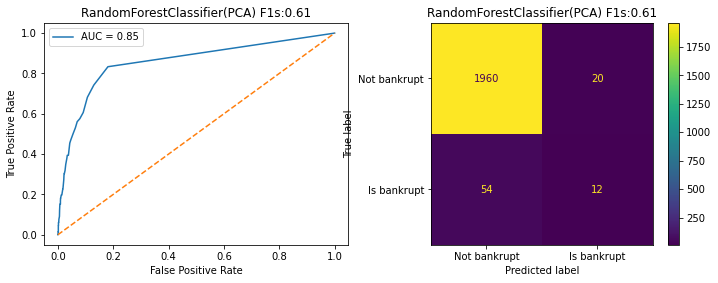

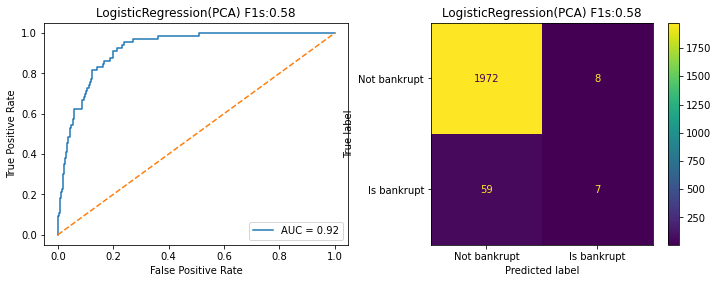

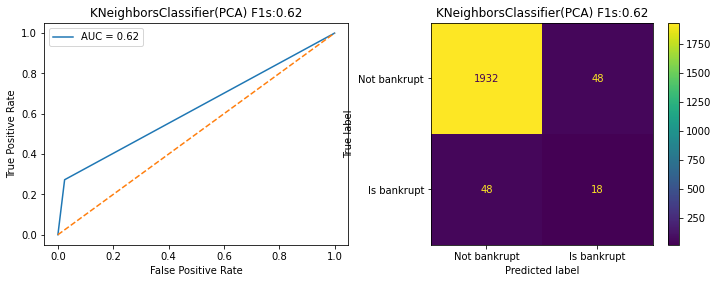

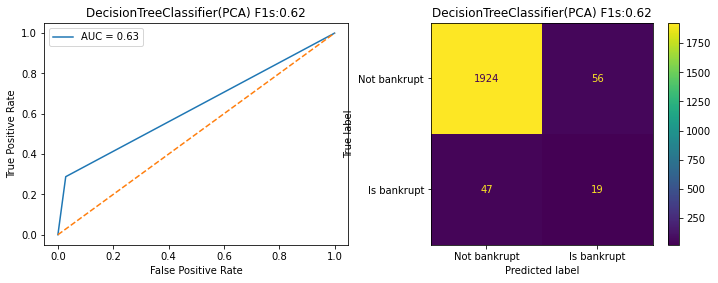

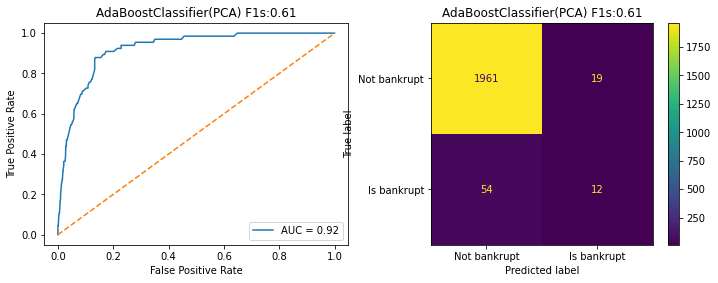

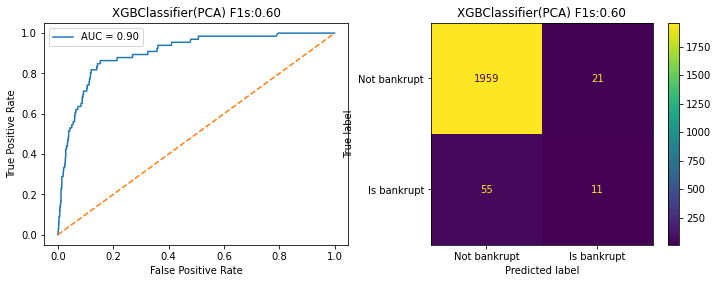

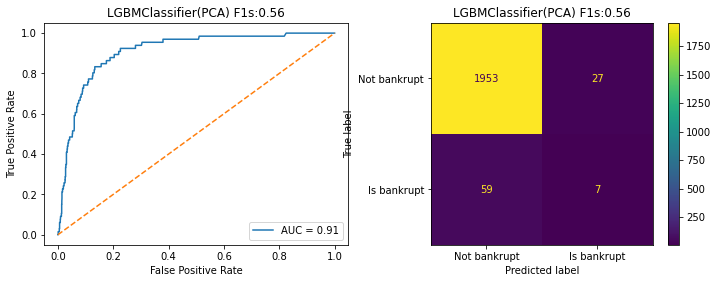

In [329]:
testModels(X_train_PCA, y_train, X_test_PCA, y_test, C_PCA, True)

## Feature Selectioon
- Removing highly correlated features
- Removing highly  VIF-scored features
- Selecting for Model Accuracy
- Selecting by Mutual Information

### Removing highly VIF-scored features

In [303]:
# calculate the correlation between target and each feature and take the absolute value
corr_df = df_rename.corr()["target"].abs()
# list of features which have at least 9% (the mean of total correlations) correlation to the target
features = corr_df[corr_df <= 0.09].index.to_list()[1:]
# drop the features in the features list
train_targetHighCorr = X_resample.drop(features, axis=1)
test_targetHighCorr = X_test.drop(features, axis=1)

In [304]:
# the mean of total correlations
corr_df.mean()

0.09116505557155978

In [305]:
train_targetHighCorr.shape

(7852, 36)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.96
LogisticRegression: train accurancy- 0.86 and test accruancy- 0.89
KNeighborsClassifier: train accurancy- 1.00 and test accruancy- 0.95
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.96
AdaBoostClassifier: train accurancy- 0.94 and test accruancy- 0.92
XGBClassifier: train accurancy- 1.00 and test accruancy- 0.96
LGBMClassifier: train accurancy- 1.00 and test accruancy- 0.96


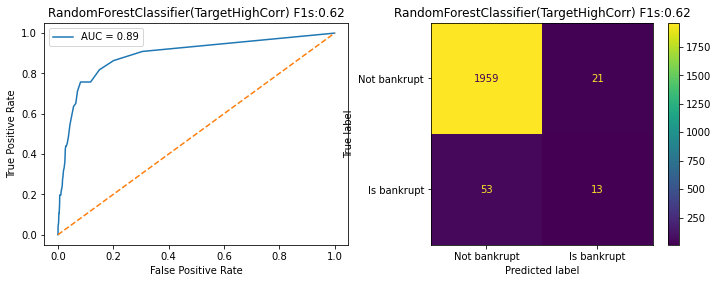

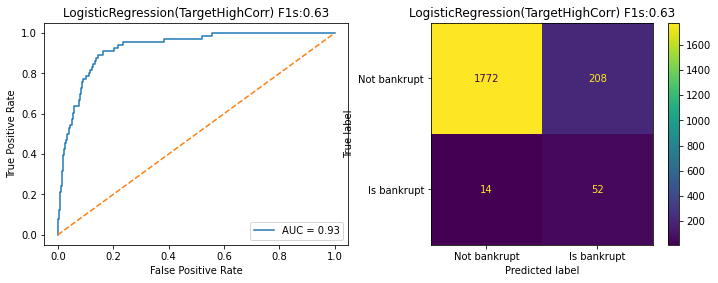

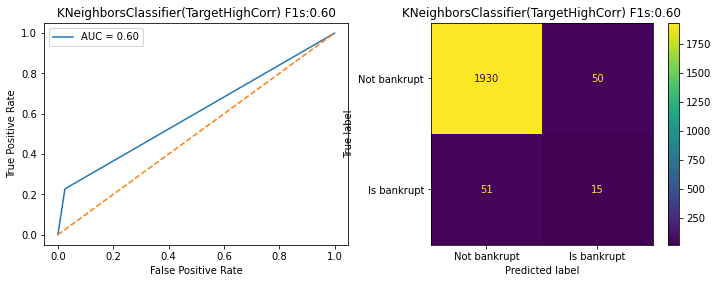

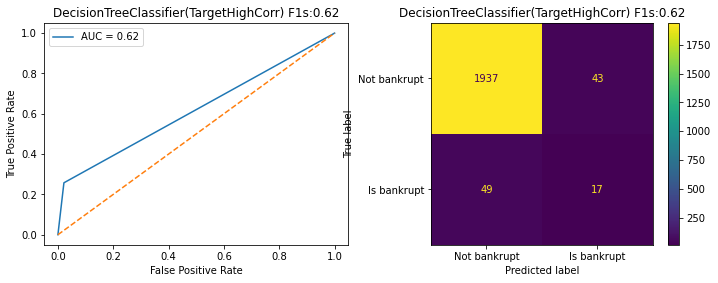

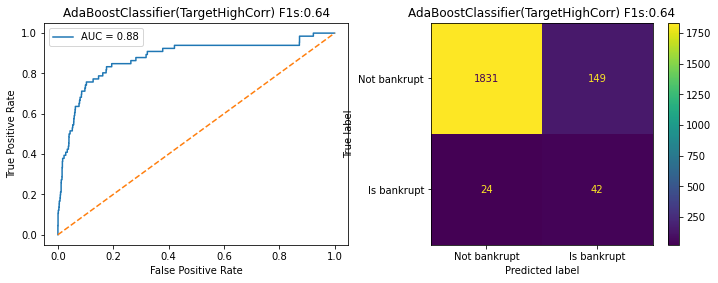

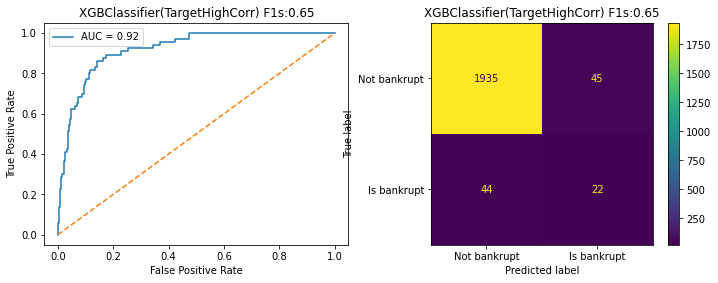

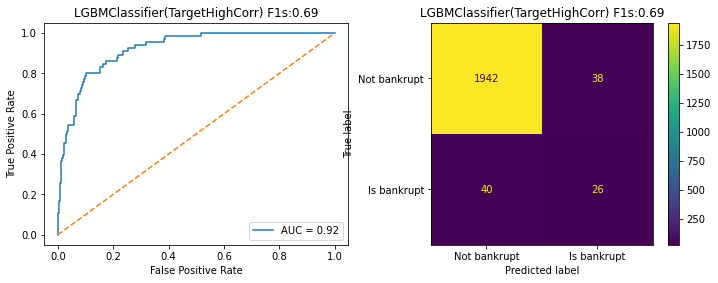

In [327]:
testModels(train_targetHighCorr, y_resample, test_targetHighCorr, y_test, C_TARGETHIGHCORR, True)

In [307]:
def drop_vif(df, vifIndex):
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in df.columns:
        # extract all the other features you will regress against
        X = [f for f in df.columns if f != feature]
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        if tolerance[feature] == 0:
            vif[feature] = 0
            continue
        vif[feature] = 1 / (tolerance[feature])
    # return drop features of VIF > vifIndex
    to_drop = [f for f in df.columns if vif[f] > vifIndex]
    return to_drop

In [308]:
# drop the features whose VIF is greater than 5 after targetHighCorr
train_remove5VIF = train_targetHighCorr.drop(drop_vif(train_targetHighCorr, 5), axis=1)
train_remove5VIF.shape
test_remove5VIF = test_targetHighCorr.drop(drop_vif(train_targetHighCorr, 5), axis=1)

RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.96
LogisticRegression: train accurancy- 0.83 and test accruancy- 0.87
KNeighborsClassifier: train accurancy- 1.00 and test accruancy- 0.95
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.91 and test accruancy- 0.91
XGBClassifier: train accurancy- 1.00 and test accruancy- 0.95
LGBMClassifier: train accurancy- 1.00 and test accruancy- 0.96


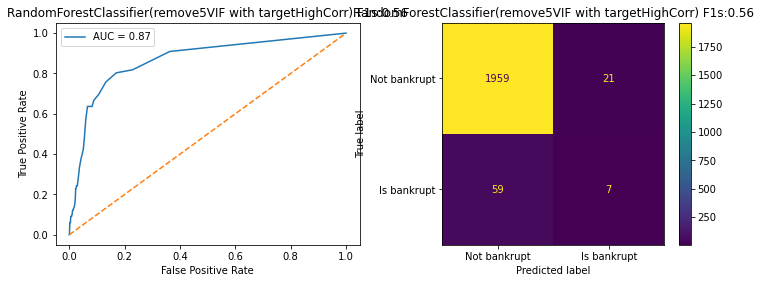

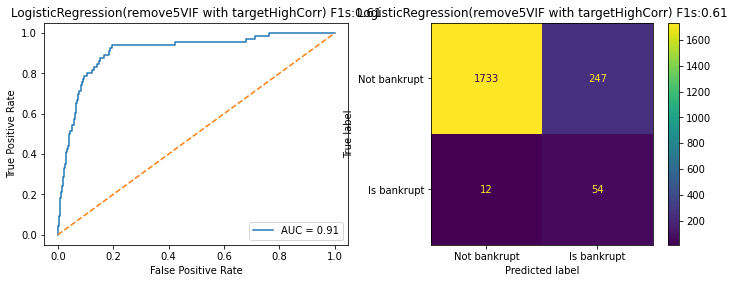

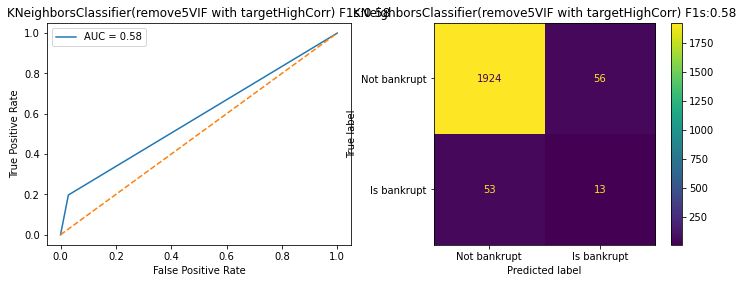

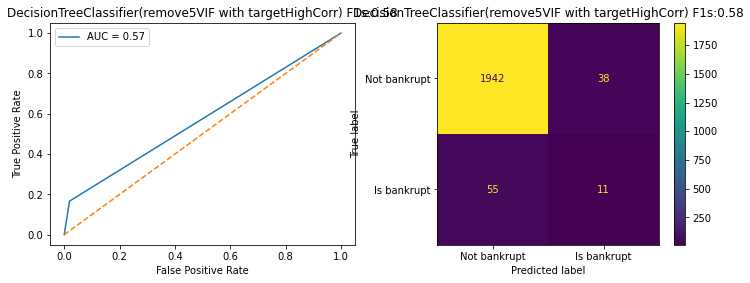

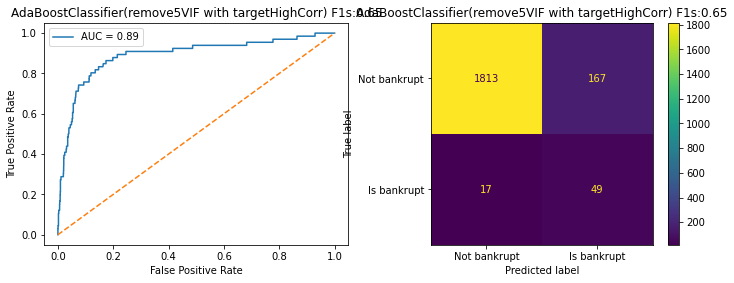

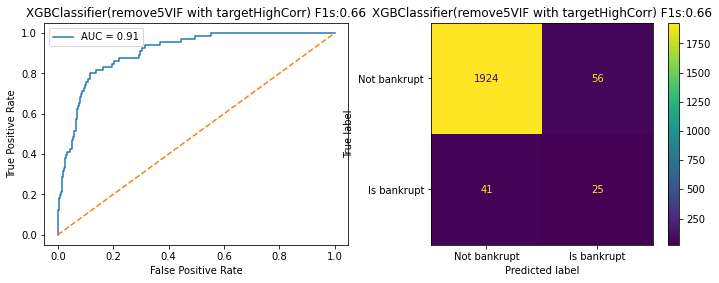

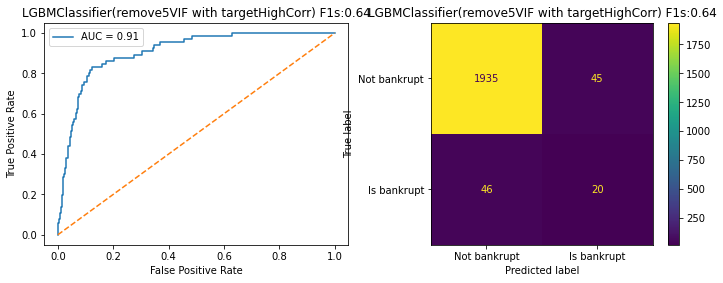

In [328]:
testModels(train_remove5VIF, y_resample, test_remove5VIF, y_test, C_REMOVE5VIF, True)

### Selecting for Model Accuracy
1. AdaBoostClassifier
2. XGBClassifier
3. DecisionTreeClassifier

we test three classifier's accuracy to decide which features to select

#### 1. Using AdaBoostClassifier() regressor which tunes the regularization strength (alpha) using cross validation

In [310]:
# 1. AdaBoostClassifier
# create and fit the LassoCV model on the training set
rfe_ab = RFE(
    estimator=AdaBoostClassifier(), n_features_to_select=10, step=19, verbose=1
)
rfe_ab.fit(X_resample, y_resample)

# calculate R squared on the test set
r_squared = rfe_ab.score(X_test, y_test)
print(f"The model explains {r_squared:.1%} of the test set variance")

# create a mask for coefficients not equal to zero
ab_mask = rfe_ab.support_
print(f"The AdaBoostClassifier() model select {sum(ab_mask)} features out of {len(ab_mask)} selected")


Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model explains 91.9% of the test set variance
The AdaBoostClassifier() model select 10 features out of 95 selected


#### 2. Using Recursive Feature Eliminator (RFE) on a XGBClassifier

In [311]:
# 2. XGBClassifier
# select 10 features with RFE and drop 19 features on each step
rfe_xgb = RFE(
    estimator=XGBClassifier(), n_features_to_select=10, step=19, verbose=1
)
rfe_xgb.fit(X_resample, y_resample)

# calculate the R squared on the test set
r_squared = rfe_xgb.score(X_test, y_test)
print(f"The model can explain {r_squared:.1%} of the variance in the test set")

# assign the support array to gb_mask
xgb_mask = rfe_xgb.support_

Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model can explain 96.3% of the variance in the test set


#### 3. Using RFE on a DecisionTreeClassifier

In [312]:
# 3. DecisionTreeClassifier
# select 10 features with RFE on a RandomForestRegressor, drop 19 feature on each step
rfe_dtc = RFE(
    estimator=DecisionTreeClassifier(), n_features_to_select=10, step=19, verbose=1
)
rfe_dtc.fit(X_resample, y_resample)

# calculate the R squared on the test set
r_squared = rfe_dtc.score(X_test, y_test)
print(f"The model can explain {r_squared:.1%} of the variance in the test set")

# assign the support array to rf_mask
dtc_mask = rfe_dtc.support_

Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model can explain 94.9% of the variance in the test set


#### 4. Using RFE on a LGBMClassifier

In [313]:
# 3. LGBMClassifier
# select 10 features with RFE on a RandomForestRegressor, drop 19 feature on each step
rfe_lgbmc = RFE(
    estimator=LGBMClassifier(), n_features_to_select=10, step=19, verbose=1
)
rfe_lgbmc.fit(X_resample, y_resample)

# calculate the R squared on the test set
r_squared = rfe_lgbmc.score(X_test, y_test)
print(f"The model can explain {r_squared:.1%} of the variance in the test set")

# assign the support array to rf_mask
lgmbc_mask = rfe_lgbmc.support_

Fitting estimator with 95 features.
Fitting estimator with 76 features.
Fitting estimator with 57 features.
Fitting estimator with 38 features.
Fitting estimator with 19 features.
The model can explain 96.3% of the variance in the test set


In [314]:
# sum the votes of the four models
votes = np.sum([ab_mask, xgb_mask, dtc_mask, lgmbc_mask], axis=0)
print("votes:", votes) # 0: not helpful, 1: only helpful for 1 model ... 4: helpful for all models

# create a mask for features selected by at least 2 model
meta_mask = votes >= 2

# apply the dimensionality reduction on X
train_modelReduceFeature = X_resample.loc[:, meta_mask]
train_modelReduceFeature.shape
test_modelReduceFeature = X_test.loc[:, meta_mask]

votes: [0 0 0 0 0 2 0 0 1 1 0 0 1 2 0 2 0 0 3 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 3 4 0
 0 0 3 0 0 0 0 0 2 2 0 0 0 2 0 1 0 0 0 2 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.96
LogisticRegression: train accurancy- 0.53 and test accruancy- 0.82
KNeighborsClassifier: train accurancy- 0.97 and test accruancy- 0.90
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.93 and test accruancy- 0.92
XGBClassifier: train accurancy- 1.00 and test accruancy- 0.96
LGBMClassifier: train accurancy- 1.00 and test accruancy- 0.96


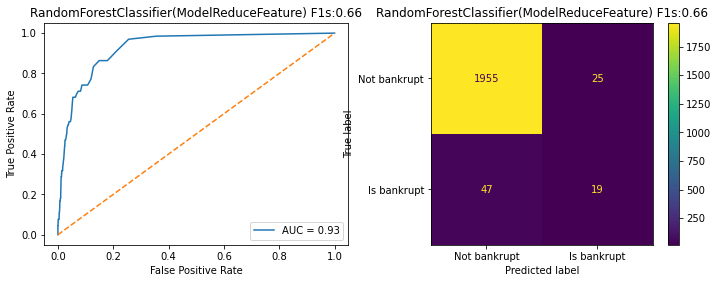

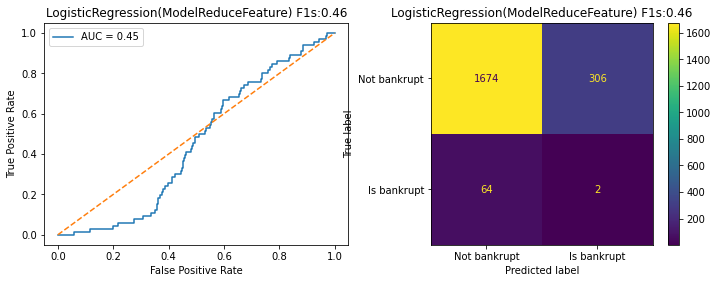

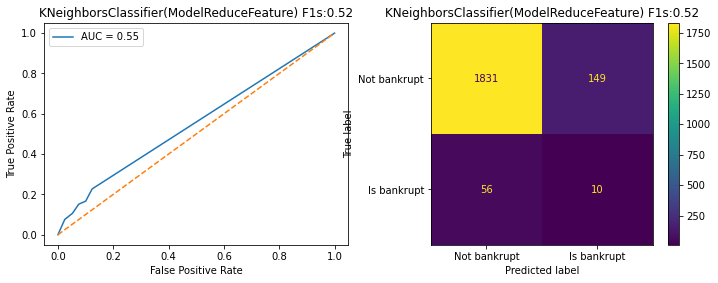

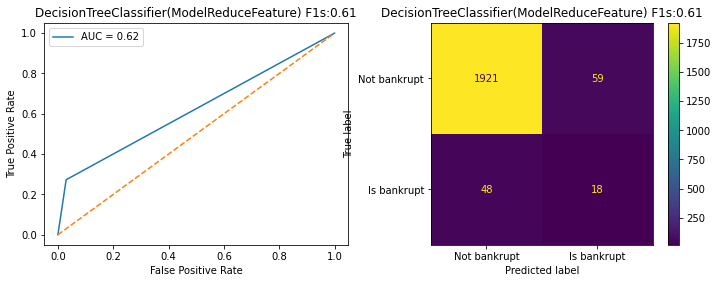

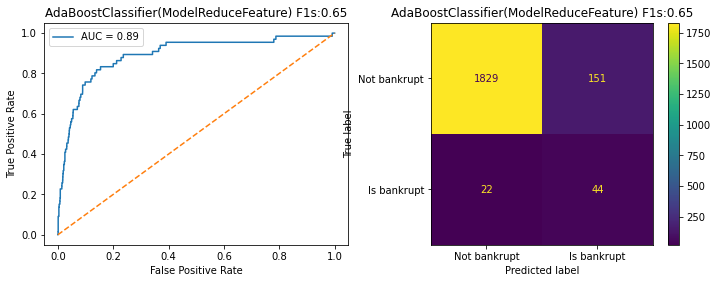

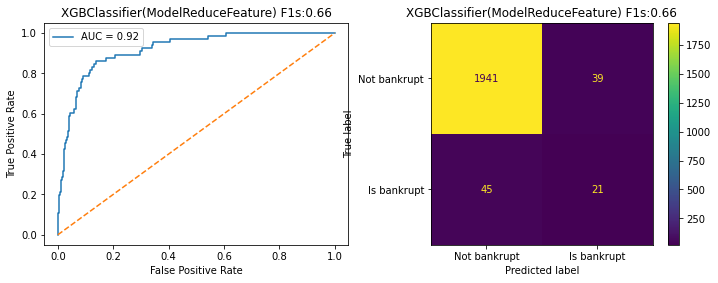

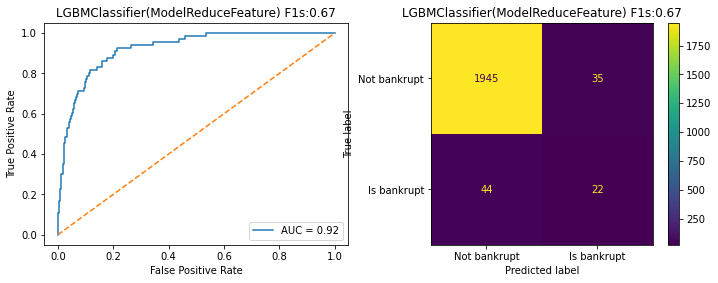

In [315]:
testModels(train_modelReduceFeature, y_resample, test_modelReduceFeature, y_test, C_MODELREDUCEFEATURE, True)

### Selecting by Mutual Infromation


The MI score will fall in the range from 0 to ∞. The higher value, the closer connection between this feature and the target, which suggests that we should put this feature in the training dataset.<br>
If the MI score is 0 or very low like 0.01. the low score suggests a weak connection between this feature and the target.

Text(0, 0.5, 'Mutual Information')

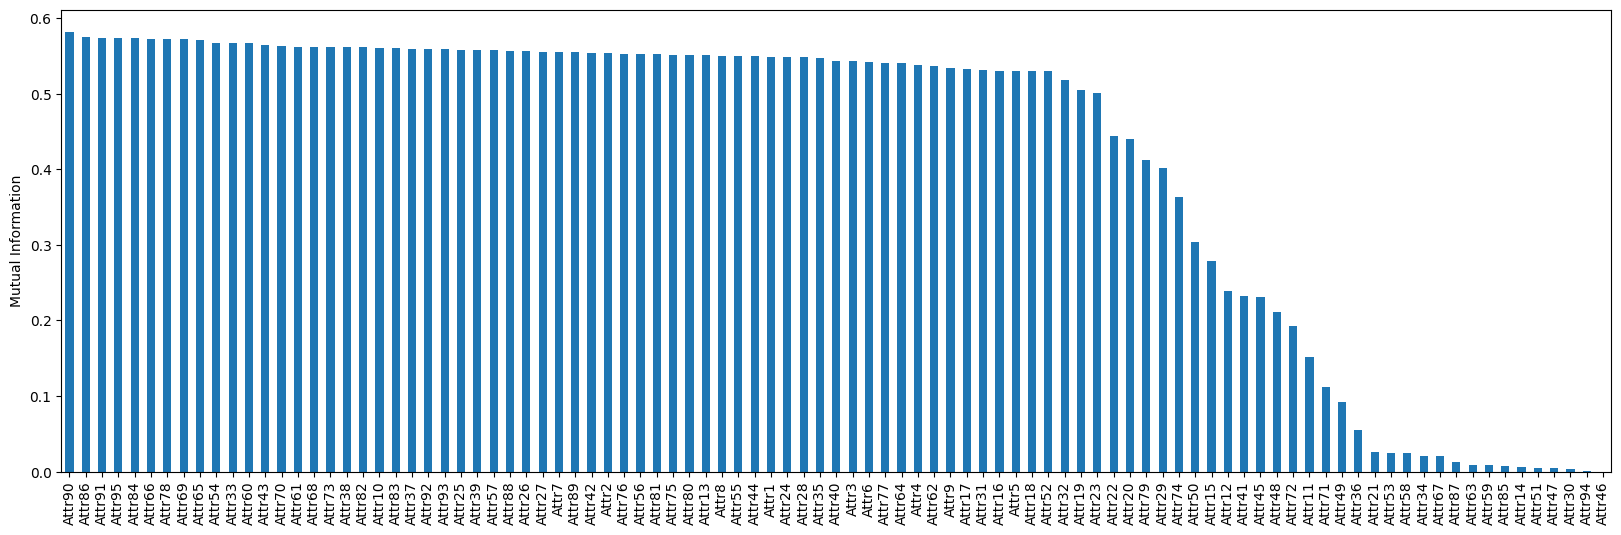

In [316]:
# the less mi value, the less information we can get from
mi = mutual_info_classif(X_resample, y_resample)
miseries = pd.Series(mi)
miseries.index = X_resample.columns
miseries.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel("Mutual Information")


In [317]:
# to find k which give us the max accuracy

# We use logistic regression to know how many k features we need to choose because it is so far least fitted one.
# Therefore, we can improve the accuracy in logistic regession as well as in other classifications.

# WARNING: this code cell takes around 12 mins
test_error_rates = []
for i in range(1, 96):
    k_best = SelectKBest(mutual_info_classif, k=i).fit(X_resample, y_resample)
    X_train_kBest = k_best.transform(X_resample)
    X_test_kBest = k_best.transform(X_test)

    md = LogisticRegression(solver="liblinear")
    md.fit(X_train_kBest, y_resample)

    y_mi_pre = md.predict(X_test_kBest)
    test_error = 1-accuracy_score(y_test, y_mi_pre)
    test_error_rates.append(test_error)

optimal_k = test_error_rates.index(min(test_error_rates))+1
print("optimal K: ", optimal_k)

optimal K:  68


In [318]:
# use optimal_k
k_best = SelectKBest(mutual_info_classif, k=optimal_k).fit(X_resample, y_resample)
X_train_kBest = k_best.transform(X_resample)
X_test_kBest = k_best.transform(X_test)
testModels(X_train_kBest, y_resample, X_test_kBest, y_test, C_KBESTMUTUALINFO, False)

In [319]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,XGBClassifier,LGBMClassifier
Original,0.636448,0.491298,0.519838,0.642474,0.661255,0.664551,0.682234
UnderSampling,0.611001,0.521652,0.452077,0.578128,0.581601,0.615889,0.620636
OverSampling,0.653226,0.512395,0.547065,0.633299,0.655234,0.690547,0.720277
SMOTE,0.692005,0.520045,0.534824,0.604186,0.669639,0.689372,0.697695
PCA,0.611821,0.578068,0.625135,0.621717,0.614575,0.602731,0.631976
TargetHighCorr,0.615221,0.635299,0.620641,0.595784,0.652575,0.680643,0.690547
remove5VIF with targetHighCorr,0.578539,0.610213,0.595253,0.592907,0.642395,0.63671,0.632782
ModelReduceFeature,0.663687,0.45559,0.517938,0.612326,0.646003,0.656077,0.66891
kBestMutualInfo,0.633452,0.491803,0.55374,0.645094,0.641643,0.682295,0.662856


## According to the above table, we choose "targetHighCorr" as final dataset for feature selection

In [320]:
X_train_final = train_targetHighCorr.copy()
X_test_final = test_targetHighCorr.copy()

X_train_final.shape, X_test_final.shape

((7852, 36), (2046, 36))

we find out that "random forest" results in overfitting problem.

## Model Selection

### Test models with hyperparameters and compare them with default hyperparameters

Using "grid search" package for hyperparameter tuning

The point of the grid that maximizes the average value in cross-validation, is the optimal combination of values for the hyperparameters.

We do not use random search because it tests only a randomly selected subset of these points. Besides, the smaller this subset, the faster but less accurate the optimization.

In [321]:
model_params = {
    "knn": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [1,5,7,11,45,51,63],  # odd number, how many neighbors we use to decide the best classfication result
            "p": [1,2,5],  # power parameter for the Minkowski metric
        },
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [1,5,7,10,45,50,6],  # the number of trees in the forest
        },
    },
    "logistic_regression": {
        "model": LogisticRegression(solver="liblinear"),
        "params": {
            "C": [1,5,9,10,
            ],  # inverse of regularization strength; must be a positive float
        },
    },
    "decision_tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [10,20,30,40]
        }       
    },
    "ada_boost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [1,5,7,10,45,50,60],  # the number of trees in the forest
        },
    },
    "XGBClassifier": {
        "model": XGBClassifier(),
        "params": {
            "min_child_weight": [1,5,10],  # the number of trees in the forest
            "max_depth": [3,4,5,6,7,8,9,10],
        },
    },
    "LGBMClassifier": {
        "model": LGBMClassifier(),
        "params": {
            "max_depth": [3,4,5,6,7,8,9,10],
        },
    },
}

In [322]:
# to find the best hyperparameters
scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp["model"], mp["params"], cv=5, return_train_score=False)
    clf.fit(X_train_final, y_resample)
    scores.append(
        {
            "model": model_name,
            "best_score": clf.best_score_,
            "best_params": clf.best_params_,
        }
    )

df = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
df

,model,best_score,best_params
0,knn,0.987264,"{'n_neighbors': 1, 'p': 2}"
1,random_forest,0.993123,{'n_estimators': 6}
2,logistic_regression,0.865259,{'C': 10}
3,decision_tree,0.985099,{'max_depth': 30}
4,ada_boost,0.937851,{'n_estimators': 60}
5,XGBClassifier,0.990194,"{'max_depth': 9, 'min_child_weight': 1}"
6,LGBMClassifier,0.990703,{'max_depth': 10}


RandomForestClassifier: train accurancy- 1.00 and test accruancy- 0.96
LogisticRegression: train accurancy- 0.86 and test accruancy- 0.89
KNeighborsClassifier: train accurancy- 1.00 and test accruancy- 0.95
DecisionTreeClassifier: train accurancy- 1.00 and test accruancy- 0.95
AdaBoostClassifier: train accurancy- 0.94 and test accruancy- 0.92
XGBClassifier: train accurancy- 1.00 and test accruancy- 0.96
LGBMClassifier: train accurancy- 1.00 and test accruancy- 0.96


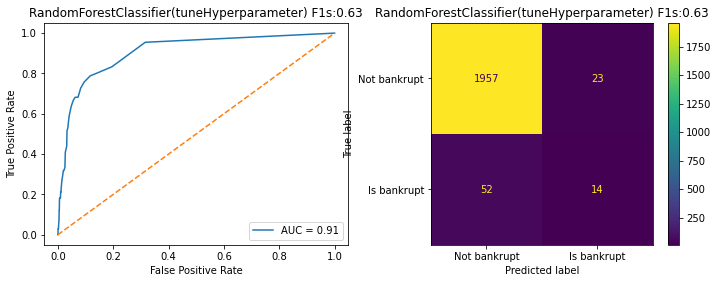

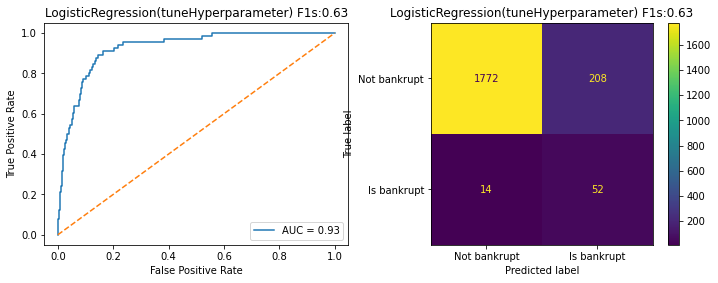

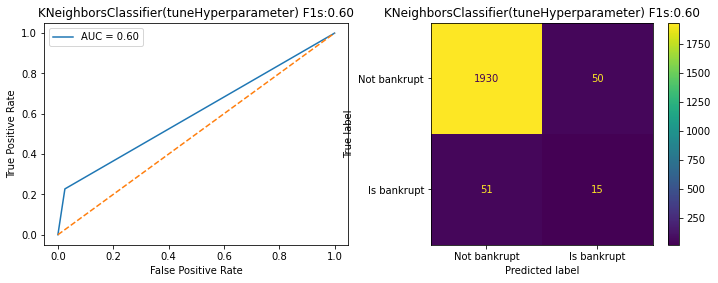

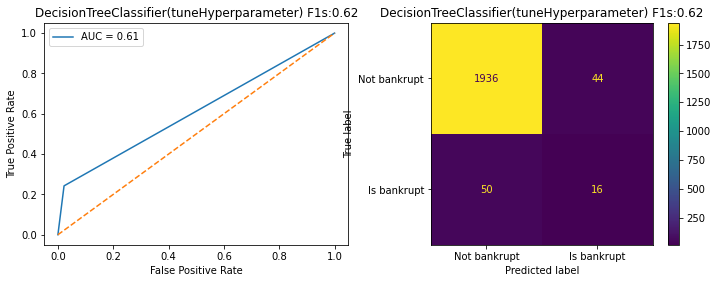

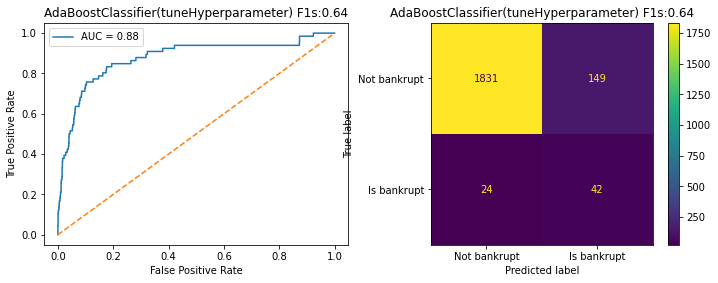

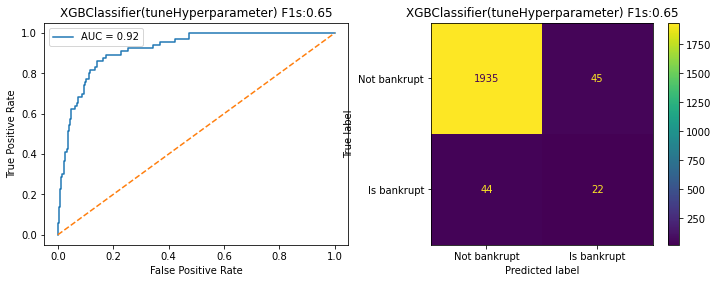

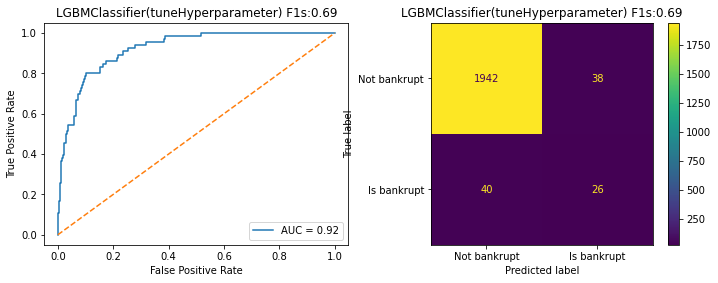

In [323]:
# display optimal solutions
optimal_models = [RandomForestClassifier(n_estimators = 50), 
                  LogisticRegression(solver = "liblinear", C = 9), 
                  KNeighborsClassifier(n_neighbors = 1, p = 2), 
                  DecisionTreeClassifier(max_depth = 40),
                  AdaBoostClassifier(n_estimators = 60),
                  XGBClassifier(min_child_weight = 1, max_depth = 4),
                  LGBMClassifier(max_depth=9)
                 ]
models = optimal_models
testModels(X_train_final, y_resample, X_test_final, y_test, C_OPT, True)

## Model Evaluation

In [331]:
models_f1Score

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,AdaBoostClassifier,XGBClassifier,LGBMClassifier
Original,0.636448,0.491298,0.519838,0.642474,0.661255,0.664551,0.682234
UnderSampling,0.611001,0.521652,0.452077,0.578128,0.581601,0.615889,0.620636
OverSampling,0.653226,0.512395,0.547065,0.633299,0.655234,0.690547,0.720277
SMOTE,0.692005,0.520045,0.534824,0.604186,0.669639,0.689372,0.697695
PCA,0.613185,0.578068,0.624242,0.621717,0.614575,0.602731,0.559228
TargetHighCorr,0.620731,0.630035,0.601755,0.623322,0.640869,0.654173,0.690156
remove5VIF with targetHighCorr,0.564463,0.612374,0.582523,0.58396,0.649612,0.657774,0.641185
ModelReduceFeature,0.663687,0.45559,0.517938,0.612326,0.646003,0.656077,0.66891
kBestMutualInfo,0.633452,0.491803,0.55374,0.645094,0.641643,0.682295,0.662856
tuneHyperparameter,0.626521,0.630035,0.601755,0.615133,0.640869,0.654173,0.690156


<Figure size 1000x600 with 0 Axes>

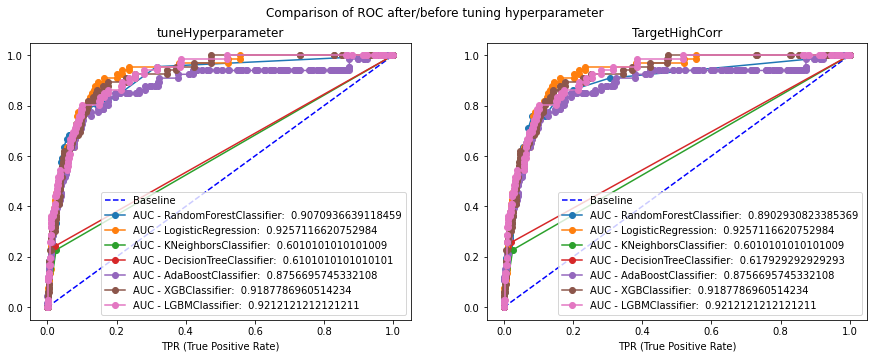

In [330]:
# plot the combined AUC curves - resample basis
plt.figure(figsize=(10, 6))

# plot figure
fig, sub_figs = plt.subplots(1, 2, sharex=False, figsize=(15, 5), dpi=72)
fig.suptitle("Comparison of ROC after/before tuning hyperparameter")

count = 0
for data_name, mds in auc_rocs.items():
    if data_name not in [C_TARGETHIGHCORR, C_OPT]:
        continue
    sub_figs[count].set_title(data_name)
    # plot the baseline model, AUC of 0.5
    sub_figs[count].plot([0, 1], [0, 1], color="blue", linestyle="--", label="Baseline")

    sub_figs[count].set_xlabel("FPR (False Positive Rate)", size=10)
    sub_figs[count].set_xlabel("TPR (True Positive Rate)", size=10) 
    for i, item in enumerate(mds):
        sub_figs[count].plot(item['fpr'], item['tpr'], "-o", label=f"AUC - {item['model_name']}:  {item['auc']}")
    sub_figs[count].legend(fontsize='medium')
    count+=1
plt.show()

# Conclusion

The data initially had imbalance of 3.23%. Different sampling techniques were used to resolve the imbalance, from which imblearn-oversampling resulted in highest accuracy of all and hence was used to balance the data. Further, in order to select the best and efficient solution, the classification models were trained using various ways of feature selection. Since "TargetHighCorr" and XGBClassifier better improved the accuracy, the data set processed by selecting features which have high correlation to the target and XGBClassifier, LGBMClassifier were selected. In addition, overfitting condition was checked by comparing different models, and it was found that only RandomForest exhibhited overfitting condition amongst other models. Further, to improve the model performance hyperparameter tuning was performed, which resulted in {feature resample - "oversampling", feature selection - "TargetHighCorr", model- XGBClassifier, "LGBM"} as the best/optimalsolution.<br>
The reason we selected two models "XGBClassifier", "LGBMClassifier" is because both of the models result in equally high accuracy.


This is our workflow:  [Project Bankruptcy_Workflow]( https://whimsical.com/ZuCpACo7XKv2sndFrSVnp)

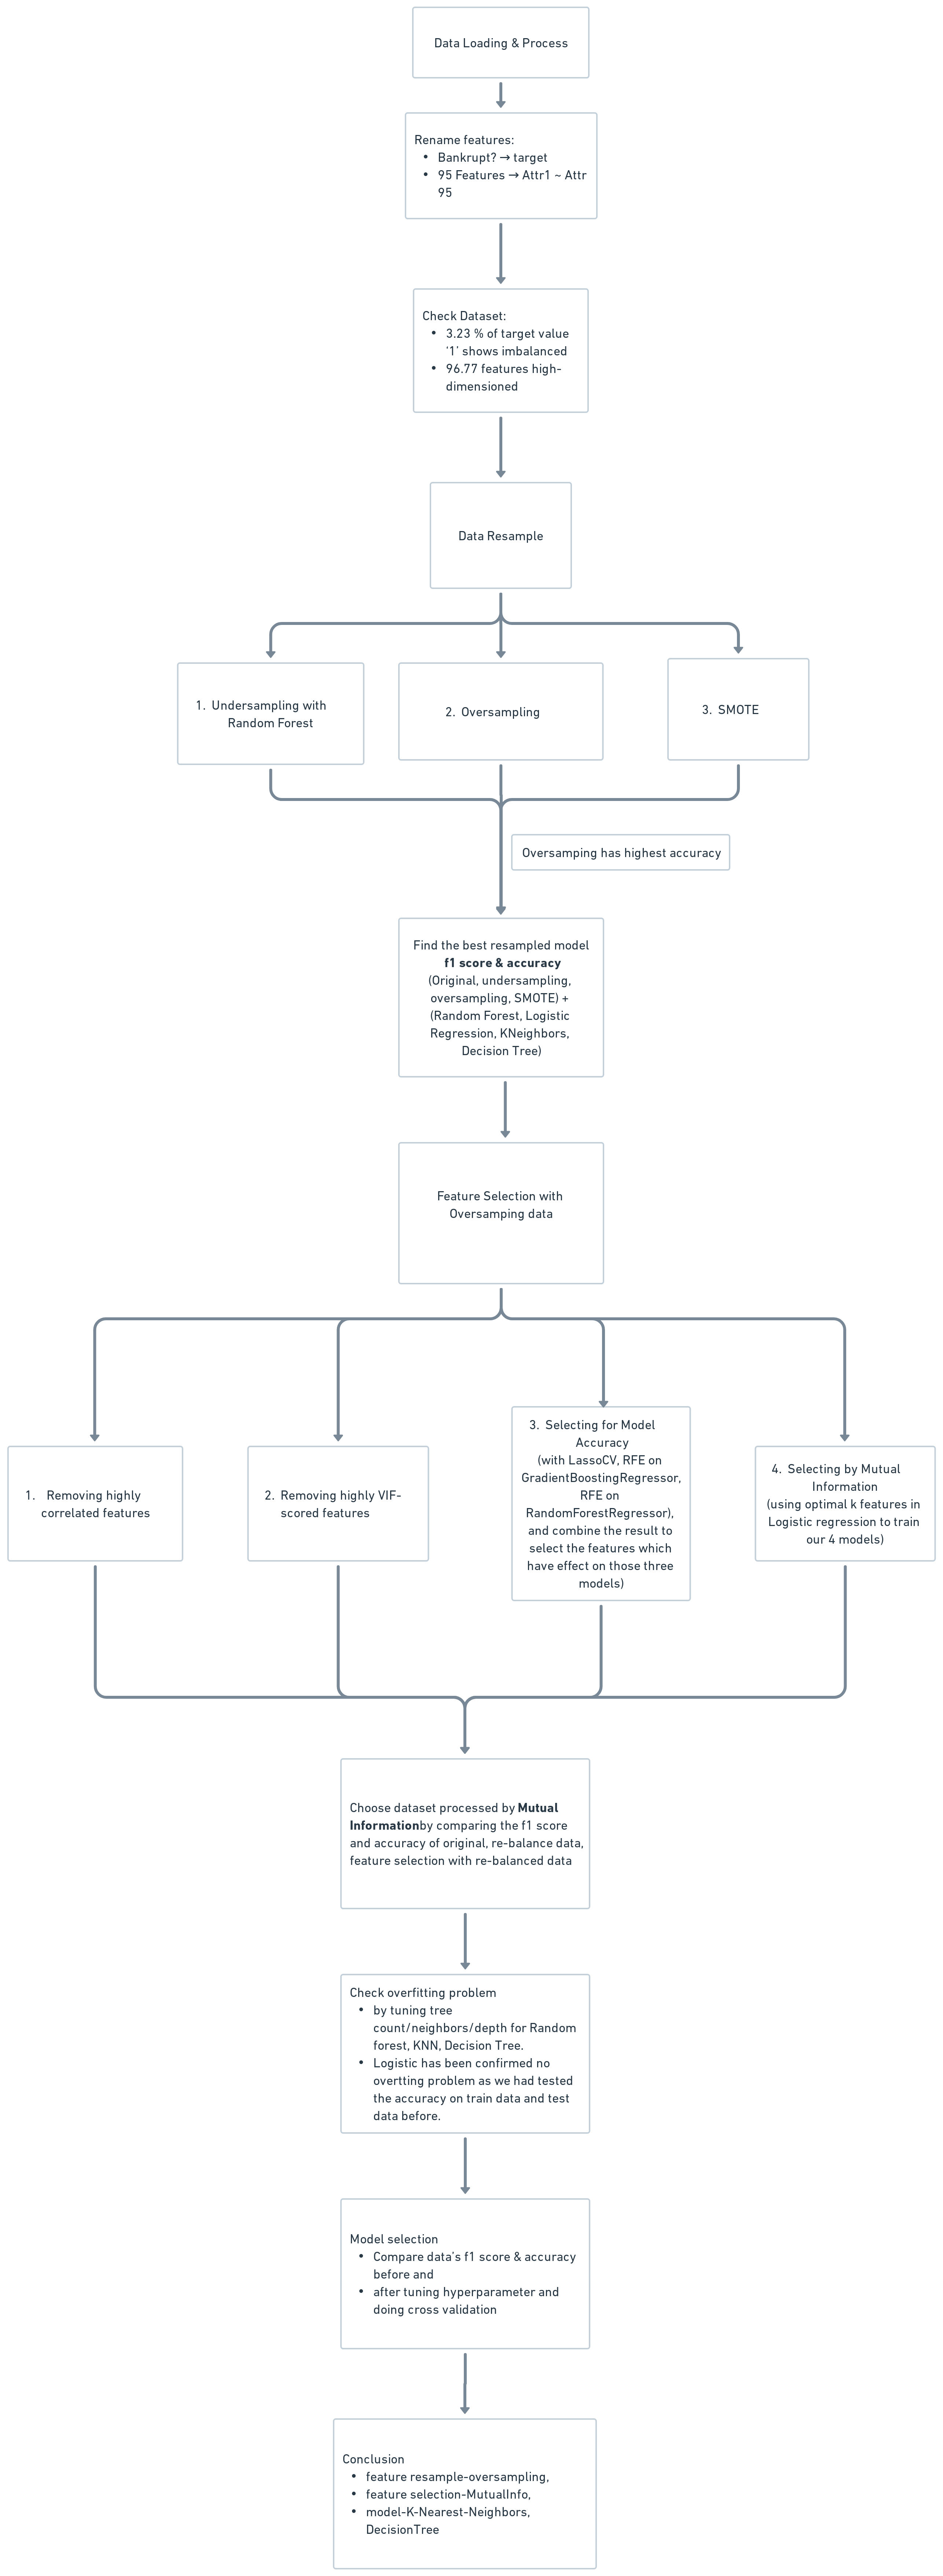